# Описание проекта: телекоммуникации
Оператор связи «Ниединогоразрыва.ком» предоставляет два основных типа услуг: 
1.	Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2.	Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
-	Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
-	Выделенная линия технической поддержки (TechSupport);
-	Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
-	Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить **каждый месяц или заключить договор на 1–2 года.** Доступны различные способы расчёта и возможность получения электронного чека.

Нужно научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


### Описание данных

Данные состоят из файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии. 

## Цель: 

Нужно научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Содержание проекта:
1. Предварительный Анализ данных - здесь мы взглянем на общую картину
2. Предобработка данных:
- здесь предполагается что мы на основе предварительных данных приведем таблицы к возможности с ними работать, создадим новые признаки;
3. Проведем исследовательский анализ:
- разделение их на выборки;
- далее предполагается кодирование признаков, через OneHotEncoder ;
6. Подберем модель (Бустинг, случайный лес)
7. Сравним модели на кросвалидации 
8. Контрольное тестирование лучшей модели на тестовой выборке
9. ROC AUC ДОЛЖЕН БЫТЬ НЕ МЕНЕЕ 0.85,

В КАЧЕСТВЕ ДОП ПРОВЕРКИ используем accuracy
Основная метрика: AUC-ROC.

Критерии оценки:
- AUC-ROC >= 0.85

In [1]:
!pip install -q phik
!pip install -U -q scikit-learn
!pip install -U -q matplotlib
!pip install -U -q seaborn
!pip install phik

In [2]:
import pandas as pd
import numpy as np 
import re


from matplotlib import pyplot as plt
import seaborn as sns 
import phik #для корелляции категориальных признаков
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             roc_auc_score)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [3]:
RANDOM_STATE = 280823

In [4]:
# загрузим данные
# загрузка данных о договоре
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
except:
    df_contract = pd.read_csv('contract_new.csv')
# загрузка информации об интернет-услугах    
try:
    df_internet_uslugi = pd.read_csv('/datasets/internet_new.csv')
except:
    df_internet_uslugi = pd.read_csv('internet_new.csv')
# загрузка персональных данных клиента    
try:
    df_personal_information = pd.read_csv('/datasets/personal_new.csv')
except:
    df_personal_information = pd.read_csv('personal_new.csv')

# загрузка информации об услугах телефонии
try:
    df_tlf = pd.read_csv('/datasets/phone_new.csv')
except:
    df_tlf = pd.read_csv('phone_new.csv')   


### Предварительный анализ данных

**Сразу развернем и взглянем на каждую таблицу**

In [5]:
def show_df(df):
    display(df.head())
    display(df.info())
    print('Явных дубликатов:',df.duplicated())

In [6]:
show_df(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Явных дубликатов: 0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Length: 7043, dtype: bool


In [7]:
show_df(df_internet_uslugi)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Явных дубликатов: 0       False
1       False
2       False
3       False
4       False
        ...  
5512    False
5513    False
5514    False
5515    False
5516    False
Length: 5517, dtype: bool


In [8]:
show_df(df_personal_information)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Явных дубликатов: 0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Length: 7043, dtype: bool


In [9]:
show_df(df_tlf)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Явных дубликатов: 0       False
1       False
2       False
3       False
4       False
        ...  
6356    False
6357    False
6358    False
6359    False
6360    False
Length: 6361, dtype: bool


Из небольшого анализа видно что:
- В каждой таблице есть столбец customerID по которому можно объединить все 4 таблицы;
- Большинство признаков(столбцов) имеют ответ 'Yes' или 'No', что наталкивает нас на мысль о кодировании;
- Пропусков ни в одной из таблиц не наблюдается;
- Регистр названия столбцов нужно будет перевести в нижний регистр и к нормальному виду кода;
- Тип данных во всех таблицах, кроме таблицы с данными о договоре определен верно; 

В таблице с договором видно невооруженным взглядом что столбцы:
1. BeginDate и EndDate имеет неверный тип данных - нужно будет поменять на DateTime
2. TotalCharges - также нужно будет поменять на float

P.S. Так как числовых значений практически нет, и основная часть категориальаня, а где есть неправильно определен тип данных - корреляцию пока проводить не стал. 

## Предобработка данных


Вспомним о цели проекта. "Нужно научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия"

То есть другими словами уйдет клиент или нет, значит перед нами задача бинарной классификации.

В таблице df_contract есть 2 столбца, BeginDate и	EndDate:
1) BeginDate - это дата подключения, начала использования услуг клиентом оператора «Ниединогоразрыва.ком»

2) EndDate -  дата отключения, или по другому - ухода клиента

Соответственно из этого следует вывод, там где в признаке EndDate есть дата значит клиент ушел, там где его нет - клиент все еще продолжает пользоваться услугами. 

На основании этого выведем новый признак таргет и в дальнейшем избавимся от столбцов BeginDate и EndDate

In [10]:
#СГЕНЕРИРУЕМ ЦЕЛЕВОЙ ПРИЗНАК 
df_contract.loc[df_contract['EndDate'] == 'No', 'target'] = 0
df_contract.loc[df_contract['EndDate'] != 'No', 'target'] = 1

In [11]:
display(df_contract.head(10))
#сразу посмотрим на количество разных классов
df_contract['target'].value_counts()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0.0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0.0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0.0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0.0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0.0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0.0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0.0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1.0


0.0    5942
1.0    1101
Name: target, dtype: int64

In [12]:
y_1=5942/7043
y_1

0.8436745704955275

In [13]:
y_2 =df_contract['target'].mean()
display(y_2)
y_1/y_2

0.15632542950447254

5.396911898274296

**Подитог**: мы создали бинарный целевой признак, исходя из этого виден дисбаланс - учтем это при построении моделей. Так как 85% людей имеют класс 0 и лишь 15% класс - 1.

**Прежде чем перейти к объединению таблиц необходимо поработать с типом признаков, сделать их корректными и вывести новые.**

In [14]:
# при обычном изменении типа данных была проблема с неявные пропусками, посмотрим из за чего они могли появиться
df_co = df_contract[df_contract['TotalCharges'] == ' ']
df_co

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0.0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0.0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0.0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,0.0


**Вывод по признаку TotalCharges:**
- Пропуски стоят , так как пользователи впервые подключились к оператору и данные потраченные за месяц еще не успели попасть в общие затраты за весь период, приравняем эти поля;

Пропуски в столбце TotalCharges были связаны с недавним подключением к оператору от 2020 - 02 - 01 , ввиду этого было принято решение заменить эти данные на данные из столбца MonthlyCharges, так как этой информацией мы владеем, а это соответственно первый месяц использования.

In [15]:
# Заменяем значения в столбце 'TotalCharges', где есть пробелы, значениями из столбца 'MonthlyCharges'
df_contract.loc[df_contract['TotalCharges'] == ' ', 'TotalCharges'] = df_contract['MonthlyCharges']

In [16]:
# как можем убедиться код сработал - двигаемся дальше
df_co = df_contract[df_contract['customerID'] == '4472-LVYGI']
df_co

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55,0.0


In [17]:
# теперь изменим тип данных на подходящий
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')

In [18]:
df_contract.info()
#тип изменен

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   target            7043 non-null   float64
dtypes: float64(3), object(6)
memory usage: 495.3+ KB


In [19]:
# создадим признак продолжительности контракта
df_contract['EndDate'] = df_contract['EndDate'].replace({'No': '2020-02-01'})
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
df_contract['duration'] = ((df_contract['EndDate'] - df_contract['BeginDate']).dt.days).astype(int)
df_contract = df_contract.drop(columns=['BeginDate', 'EndDate'])

In [20]:
df_contract

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0.0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0.0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0.0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0.0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0.0,153
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,2035.20,0.0,730
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7430.40,0.0,2191
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,325.60,0.0,337
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,520.80,0.0,215


**Теперь думаю можно объединять таблицы**

Объединение будем производить через метод Left от таблиц с большим кол-ом строк к меньшим, чтобы не потерять данные.

In [21]:
data_full = df_personal_information.merge(df_contract, how='left', on='customerID')
data_full = data_full.merge(df_tlf, how='left', on='customerID')
data_full = data_full.merge(df_internet_uslugi, how='left', on='customerID')
data_full = data_full.set_index('customerID')

In [22]:
#Переведем все названия столбцлв в нижний регистр
data_full.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data_full.columns]

In [23]:
data_full

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,0.0,31,NaN,DSL,No,Yes,No,No,No,No
5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,2071.84,0.0,1036,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,0.0,123,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,0.0,1371,NaN,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,0.0,153,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes,One year,Yes,Mailed check,84.80,2035.20,0.0,730,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
2234-XADUH,Female,0,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7430.40,0.0,2191,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
4801-JZAZL,Female,0,Yes,Yes,Month-to-month,Yes,Electronic check,29.60,325.60,0.0,337,NaN,DSL,Yes,No,No,No,No,No


### Вопросы ревьюеру

**Вопрос №1** На вебинаре обсуждалось необходимость добавления нового столбца с сроком использования и затрагивалась тема подглядывания. 

Не совсем понимаю в каком случаи будет подглядывания и как правильно создать признак чтобы этого подглядывания не происходило. 

Если я правильно понял нужно после создания целевого признака, всем значениям 'No' в столбце ENDDate добавить 2020.02.01 , привести столбцы ENDDate и BeginDate к типу DateTime и далее создать новый столбец с количеством месяцев, верно?

**Вопрос №2**

Данные признаки не вижу необходимыми для прогноза, можно ли от них отказаться уже на данном этапе?
А далее если модель будет не справляться то включить их обратно


OnlineSecurity - наличие услуги онлайн-безопасности 

OnlineBackup - наличие услуги онлайн-резервного копирования 

**Вопрос №3**

Удалять ли столбец с CustomerId или оставить как индекс пока?

 <div class="alert alert-info">
<font size="2"> P.S. Ну и в целом если дашь полезные наводки - желательной максимально простым языком, так как в программировании я совсем новичок - буду благодарен) &#8659;</font> 

## Перейдем к анализу данных, их мультиколлинеарности и попробуем сократить кол-во столбцов

In [24]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   type               7043 non-null   object 
 5   paperless_billing  7043 non-null   object 
 6   payment_method     7043 non-null   object 
 7   monthly_charges    7043 non-null   float64
 8   total_charges      7043 non-null   float64
 9   target             7043 non-null   float64
 10  duration           7043 non-null   int64  
 11  multiple_lines     6361 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support  

**Подитог:**

Как можно заметить, после объединения таблиц образовалось много пустых ячеек, логично предположить что пустые поля равноценны значению No этих столбцов.

Оставлять пустыми столько строк для обучения модели никак не годится, заполним их текстовым значением типа object.

In [25]:
#заполнимм пропуски в новых признаках
data_full['multiple_lines'].fillna('Not info', inplace=True) #введем 3-е обозначение
data_full['internet_service'].fillna('No', inplace=True)
data_full['online_security'].fillna('No', inplace=True)  
data_full['online_backup'].fillna('No', inplace=True)    
data_full['device_protection'].fillna('No', inplace=True) 
data_full['tech_support'].fillna('No', inplace=True)    
data_full['streaming_t_v'].fillna('No', inplace=True)  
data_full['streaming_movies'].fillna('No', inplace=True) 

In [26]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   type               7043 non-null   object 
 5   paperless_billing  7043 non-null   object 
 6   payment_method     7043 non-null   object 
 7   monthly_charges    7043 non-null   float64
 8   total_charges      7043 non-null   float64
 9   target             7043 non-null   float64
 10  duration           7043 non-null   int64  
 11  multiple_lines     7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support  

Пропуски заполнены.

In [27]:
#навсякий случай пока все категориальные признаки выпишем в отдельную переменную
categorial_evidence = [ 'target', 'partner','dependents', 'type', 'paperless_billing',\
                       'payment_method', 'internet_service','online_security',\
                       'online_backup','device_protection','tech_support', 'streaming_t_v', 'streaming_movies','multiple_lines']
#и все числовые признаки выпишем в отдельную переменную
evidence = [ 'target', 'monthly_charges', 'total_charges', 'duration']

/tmp/ipykernel_48/1232399979.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


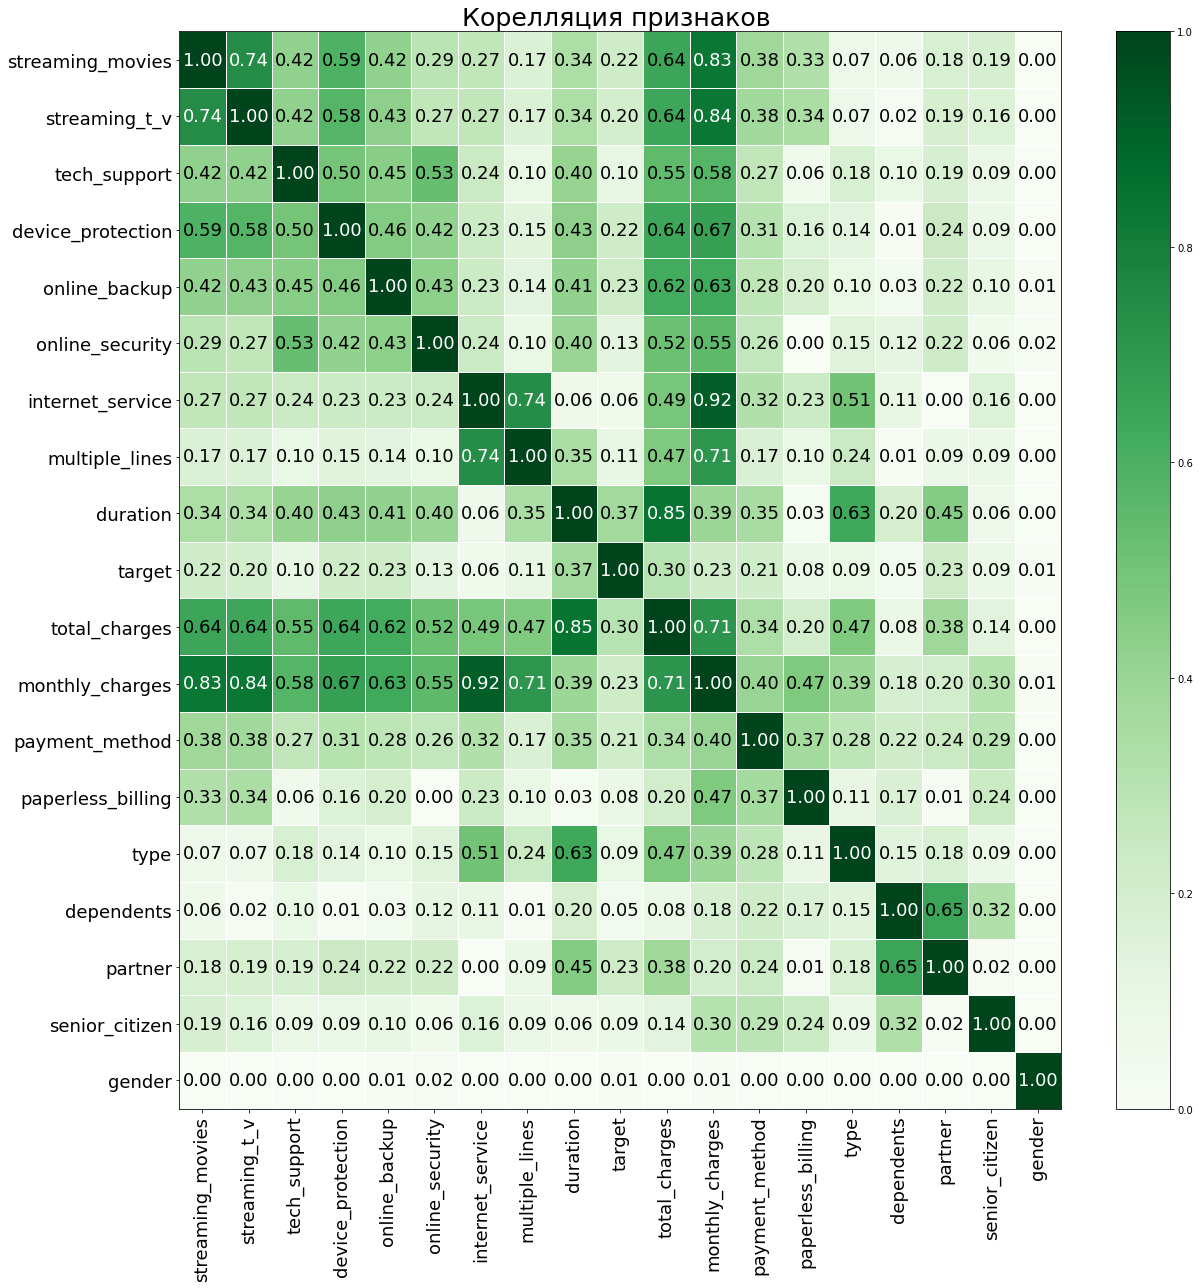

In [28]:
phik = data_full.phik_matrix(interval_cols=evidence)

plot_correlation_matrix(phik.values, 
                        x_labels=phik.columns, 
                        y_labels=phik.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r'Корелляция признаков ', 
                        fontsize_factor=1.8, 
                        figsize=(18, 18))
plt.tight_layout()

### Важная теоритическая часть

**Мультиколлинеарность — корреляция независимых переменных, которая затрудняет оценку и анализ общего результата. Когда независимые переменные коррелируют друг с другом, говорят о возникновении мультиколлинеарности. В машинном обучении (Machine Learning) мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату.** 

Исходя из текста выше, все признаки которые сильно кореллируют друг с другом будем  удалять.

In [29]:
#Удаляем признаки с высокой взаимосвязью между собой(не учитывая целевой)
data_full = data_full.drop(columns=['internet_service', 'streaming_t_v', 'streaming_movies'])

/tmp/ipykernel_48/2594462794.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


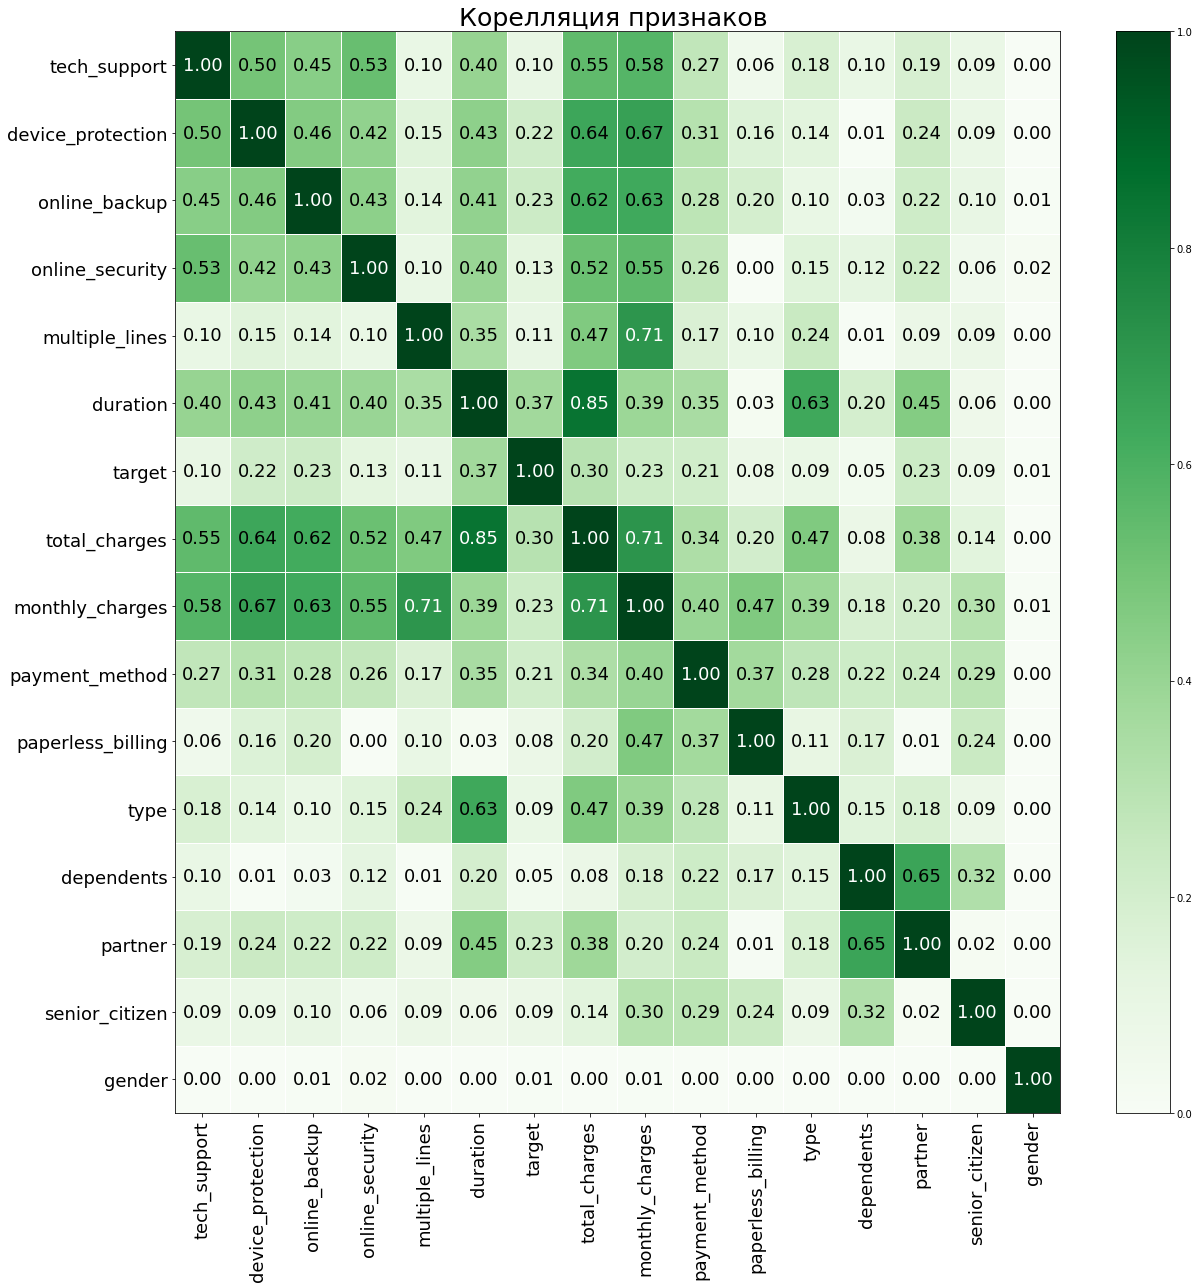

In [30]:
#Посмотрим еще раз на результат корелляции после удаления
phik = data_full.phik_matrix(interval_cols=evidence)

plot_correlation_matrix(phik.values, 
                        x_labels=phik.columns, 
                        y_labels=phik.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r'Корелляция признаков ', 
                        fontsize_factor=1.8, 
                        figsize=(18, 18))
plt.tight_layout()

**После удаления некоторых признаков взаимосвязь осталась между двумя признаками -total_charges и duration. Привязка к срокам имеет более важное значение нежели общие затраты, общие затраты можно сложить и из ежемесячных если потребуется. Удаляем Общие траты то есть признак total_charges**

In [31]:
data_full = data_full.drop(columns=['total_charges'])

In [32]:
categorial_evidence = ['partner','gender','dependents', 'type', 'paperless_billing',\
                       'payment_method','online_security',\
                       'senior_citizen','online_backup','device_protection','tech_support','multiple_lines']

In [33]:
data_full

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,target,duration,multiple_lines,online_security,online_backup,device_protection,tech_support
customerID,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,0.0,31,Not info,No,Yes,No,No
5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,0.0,1036,No,Yes,No,Yes,No
3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,0.0,123,No,Yes,Yes,No,No
7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,0.0,1371,Not info,Yes,No,Yes,Yes
9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,0.0,153,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes,One year,Yes,Mailed check,84.80,0.0,730,Yes,Yes,No,Yes,Yes
2234-XADUH,Female,0,Yes,Yes,One year,Yes,Credit card (automatic),103.20,0.0,2191,Yes,No,Yes,Yes,No
4801-JZAZL,Female,0,Yes,Yes,Month-to-month,Yes,Electronic check,29.60,0.0,337,Not info,Yes,No,No,No


### Cравним распределения признаков для ушедших и оставшихся клиентов

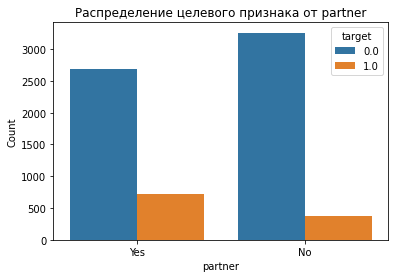

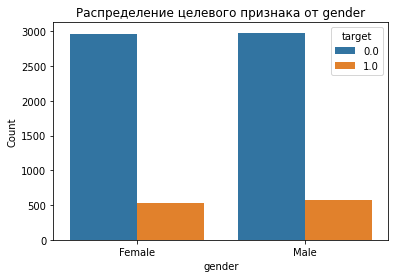

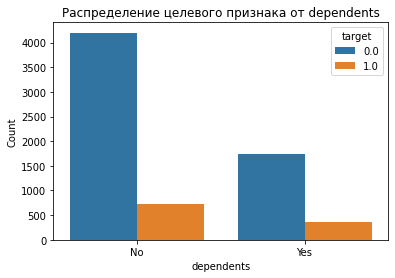

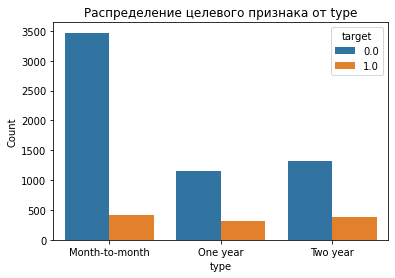

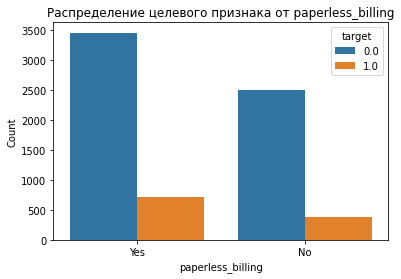

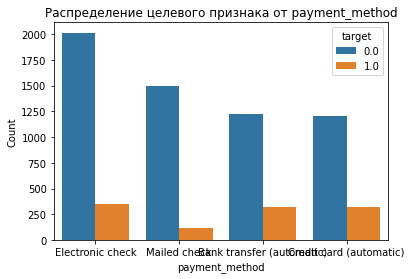

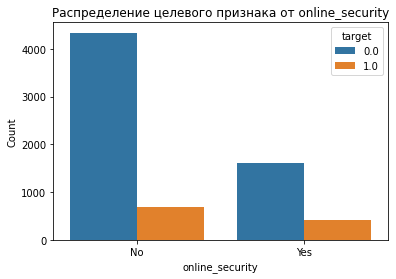

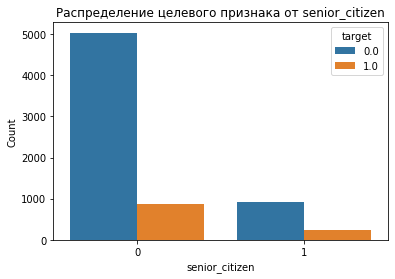

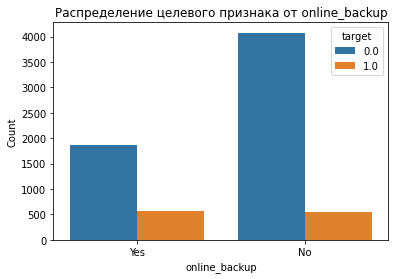

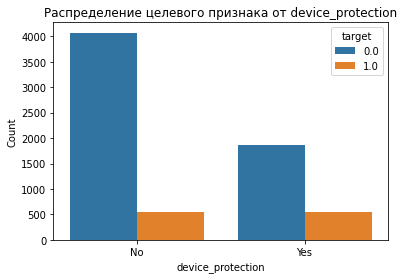

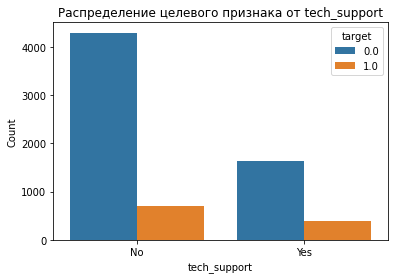

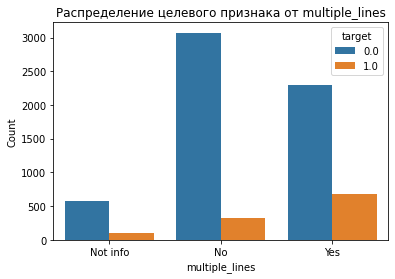

In [34]:
# цикл по признакам
for feature in categorial_evidence:
    # создание графика
    
    sns.countplot(x=feature, hue="target", data=data_full)
    figsize=(14, 12)
    plt.title(f"Распределение целевого признака от {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    
    plt.show()

       monthly_charges     duration
count      7043.000000  7043.000000
mean         64.761692   898.555729
std          30.090047   683.130510
min          18.250000     0.000000
25%          35.500000   276.000000
50%          70.350000   761.000000
75%          89.850000  1461.000000
max         118.750000  2314.000000


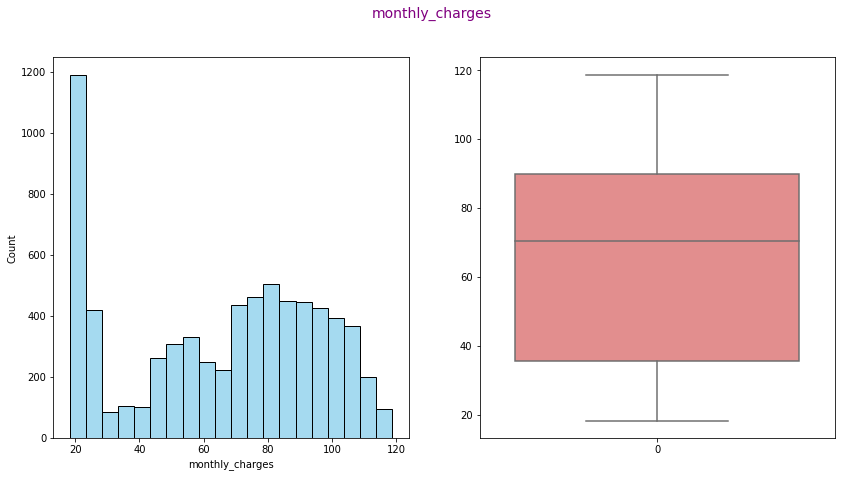

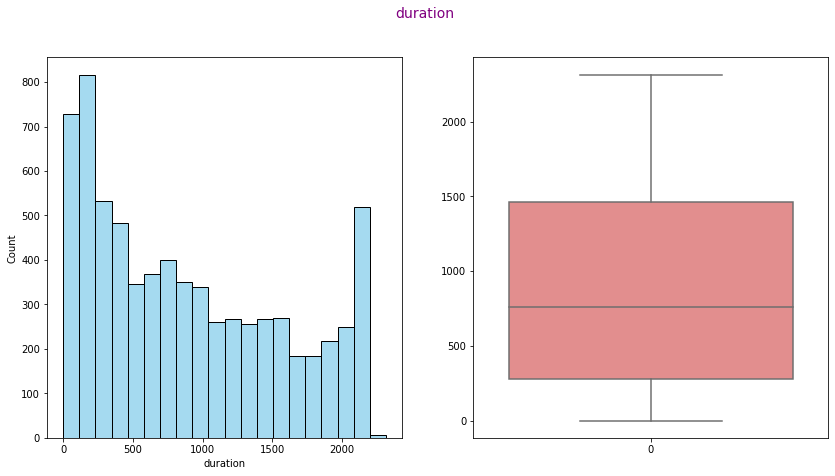

In [35]:
def graph(data, column):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    
    hist_color = 'skyblue'
    box_color = 'lightcoral'
    
    sns.histplot(data[column], bins=20, ax=ax[0], color=hist_color)
    sns.boxplot(data[column], ax=ax[1], color=box_color)
    
    fig.suptitle(column, size=14, color='purple') 
    plt.show()



print(data_full[['monthly_charges', 'duration']].describe())

# Изменяем цвета для графиков, передавая их как аргументы
for column, hist_color, box_color in [('monthly_charges', 'blue', 'red'),
                                      ('duration', 'green', 'orange')]:
    graph(data_full, column)

### Выводы по  ушедшим клиентам исходя из нецелевых признаков и по блоку:


- в 2,5 раза меньше людей уходят у которых есть партнер 700 против 250
- пол человека в данном случаи не оказывает существенного влияния, однако отметим при прочих равных мужчин уходит на несколько единиц больше, что в целом не влияет на общую картину;
- в 2 раза больше уходят и меняют оператора люди которые не имеют иждевенцев, вероятно они имеют больше времени на мониторинг и в этом смысле менее стабильны для компании, к ним нужно больше внимания и улучшения условий, хотя нельзя не заметить что в выборке количество таких клиентов тоже в 2 раза больше;
- тип контракта влияние на отток не оказывает, а если и оказывает то очень незначительное;
- клиенты оплачивающие безналичным расчетом в 2 раза более склонны к уходу нежели люди оплачивающие другой формой;
- отсутсвие услуги онлайн безопасности побуждает людей чаще менять оператора;
- уходящие клиенты чаще пенсионеры нежели наоборот;
-  OnlineBackup - наличие услуги онлайн-резервного копирования никак не оказывает влияния на отток клиентов;
- DeviceProtection - наличие услуги защиты устройств никак не оказывает влияния на отток клиентов;
- TechSupport - наличие услуги технической поддержки оказывает явное воздействие на отток, у тех клиентов у которых она отсутсвует;
- MultipleLines - наличие возможности ведения параллельных линий во время звонка оказывает воздействие на отток, у клиентов у которых она есть примерно в 2.5 раза чаще уходят.

Пенсионеры в общей выборке встречаются в 5 раз чаще, а люди оформившие подписку на месяц в 3 раза чаще. 
Уходящий клиент в основном отказывается от доп услуг для интернета.

- В данных отсутствуют дубликаты;
- В данных отсутствуют пропуски;
- В данных отсутсвуют аномальные значения;
- В данных больше нет мультиколлениарности;

**Переходим к следующему блоку**


## Разделение на выборки

In [36]:
features = data_full.drop('target', axis=1)
target = data_full['target']

In [37]:
features_train,features_test, target_train, target_test = train_test_split(\
                        features, target, test_size=0.25, stratify = target , random_state=RANDOM_STATE) 
print(features.shape)
print(target.shape)
print(features_train.shape)  # 75%
print(target_train.shape)    # 75%
print(features_test.shape)   # 25%
print(target_test.shape)     # 25%

#stratify - сохраняет уровень дисбаланса в подвыборках

(7043, 14)
(7043,)
(5282, 14)
(5282,)
(1761, 14)
(1761,)


## Кодирование таблицы

In [38]:
#кодирование Применяем One Hot Encoding к обучающей выборке
encoder_ohe = OneHotEncoder(drop ='first', handle_unknown='ignore', sparse=False)


encoder_ohe.fit(features_train[categorial_evidence])

features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[categorial_evidence])

features_train = features_train.drop(categorial_evidence, axis=1) # удаляем старые столбцы которые мы размножили

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [39]:
features_train.head()

,monthly_charges,duration,partner_Yes,gender_Male,dependents_Yes,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,online_security_Yes,senior_citizen_1,online_backup_Yes,device_protection_Yes,tech_support_Yes,multiple_lines_Not info,multiple_lines_Yes
customerID,,,,,,,,,,,,,,,,,,
9220-CXRSC,61.40,2102,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1029-QFBEN,19.55,153,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0886-QGENL,101.25,426,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4423-JWZJN,90.25,1949,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3179-GBRWV,64.95,641,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [40]:
#кодирование Применяем One Hot Encoding к тестовой выборке

# encoder_ohe.fit(features_test[categorial_evidence])

features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[categorial_evidence])

features_test = features_test.drop(categorial_evidence, axis=1) # удаляем старые столбцы которые мы размножили

In [41]:
features_test.head()

,monthly_charges,duration,partner_Yes,gender_Male,dependents_Yes,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,online_security_Yes,senior_citizen_1,online_backup_Yes,device_protection_Yes,tech_support_Yes,multiple_lines_Not info,multiple_lines_Yes
customerID,,,,,,,,,,,,,,,,,,
8884-ADFVN,101.95,306,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1431-CYWMH,19.05,671,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8591-TKMZH,111.10,1798,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
6982-SSHFK,44.40,153,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1285-OKIPP,79.90,62,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение моделей и выбор лучшей

### 1. RandomForestClassifier

Поскольку при вычислении показаетля ROC AUC балансировка  не влияет на значение функционала, мы это будем использовать исключительно постольку поскольку или вовсе откажемся.

In [42]:
target_train.value_counts()

0.0    4456
1.0     826
Name: target, dtype: int64

In [43]:
my_cv=4

In [44]:
%%time
# создаем модель
model_forest = RandomForestClassifier(random_state=RANDOM_STATE)

# задаем сетку параметров для перебора
param_grid = {
    'n_estimators': [50, 100, 230],
    'max_depth': [4, 7, 9],
    'class_weight': ['balanced']
}

# задаем метрики для оценки качества модели
scoring = {'AUC_ROC': 'roc_auc', 'Accuracy': 'accuracy'}

# выполняем поиск лучших параметров и оценку качества модели с помощью кросс-валидации
grid_search_forest = GridSearchCV(model_forest, param_grid=param_grid, cv=my_cv, scoring=scoring, refit='AUC_ROC')
#Параметр refit в GridSearchCV указывает на метрику оценки качества модели, которую нужно 
#использовать для выбора лучшей модели после перекрестной проверки.
grid_search_forest.fit(features_train, target_train)

# выводим результаты
print("Лучшие параметры:", grid_search_forest.best_params_)
print("AUC_ROC:", grid_search_forest.best_score_)


Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 100}
AUC_ROC: 0.8209459068305057
CPU times: user 16.7 s, sys: 62 ms, total: 16.7 s
Wall time: 16.9 s


**Подитог по моделе RandomForestClassifier:**

Результат метрики AUC_ROC составил 0.82, что меньше требуего значения <0.85, модель не подходит для работы.

### CatBoostClassifier

In [45]:
%%time
# задание параметров для модели
params = {'iterations': [130,140,150],
          'learning_rate': [0.01,0.15, 0.05],
          'depth': [3,4,5]}

# создание модели
model = CatBoostClassifier(class_weights=[1, 5.3],random_state=RANDOM_STATE)

# выполнение поиска по сетке для определения лучших параметров модели
grid_search = GridSearchCV(model, params, cv=my_cv, scoring='roc_auc')
grid_search.fit(features_train, target_train)

# вывод лучших параметров модели


# обучение модели с лучшими параметрами на кросс-валидации
model_cv = CatBoostClassifier(iterations=grid_search.best_params_['iterations'],
                              learning_rate=grid_search.best_params_['learning_rate'],
                              depth=grid_search.best_params_['depth'])
scores = cross_val_score(model_cv, features_train, target_train, cv=my_cv, scoring='roc_auc')

# вывод результатов кросс-валидации
print("Лучшие параметры модели:", grid_search.best_params_)
print("Результаты кросс-валидации:", scores)
print("Среднее значение roc_auc:", scores.mean())

0:	learn: 0.6915173	total: 50.8ms	remaining: 6.55s
1:	learn: 0.6896071	total: 51.8ms	remaining: 3.32s
2:	learn: 0.6879025	total: 52.8ms	remaining: 2.23s
3:	learn: 0.6862602	total: 53.6ms	remaining: 1.69s
4:	learn: 0.6844825	total: 54.7ms	remaining: 1.37s
5:	learn: 0.6827710	total: 55.6ms	remaining: 1.15s
6:	learn: 0.6813532	total: 56.5ms	remaining: 993ms
7:	learn: 0.6797358	total: 57.4ms	remaining: 875ms
8:	learn: 0.6783844	total: 58ms	remaining: 780ms
9:	learn: 0.6768988	total: 58.7ms	remaining: 704ms
10:	learn: 0.6756302	total: 59.2ms	remaining: 640ms
11:	learn: 0.6740404	total: 59.8ms	remaining: 588ms
12:	learn: 0.6725558	total: 60.4ms	remaining: 544ms
13:	learn: 0.6709509	total: 61ms	remaining: 506ms
14:	learn: 0.6693767	total: 61.6ms	remaining: 473ms
15:	learn: 0.6679502	total: 62.2ms	remaining: 443ms
16:	learn: 0.6664620	total: 62.8ms	remaining: 418ms
17:	learn: 0.6649535	total: 63.8ms	remaining: 397ms
18:	learn: 0.6635080	total: 64.7ms	remaining: 378ms
19:	learn: 0.6620655	total

**Подитог по моделе CatBoostClassifier:**

Результат метрики AUC_ROC составил 0.855, что соответствует требованию, модель подходит для работы.
Осталось проверить данные парамтеры на тестовой выборке - если подтверждается , результат достигнут.

Лучшие гиперпараметры:
* depth: 5
* iterations: 150
* learning_rate: 0.15
* Лучший AUC_ROC: 0.86951968

### Проверка лучшей модели на тестовой выборке

In [46]:
# получаем лучшую модель
best_model = grid_search.best_estimator_
# делаем предсказания на тестовой выборке
y_pred = best_model.predict(features_test)
display(y_pred)
# оцениваем качество модели на тестовой выборке
y_proba = best_model.predict_proba(features_test)[:, 1]
display(y_proba)
auc_roc_cat = roc_auc_score(target_test, y_proba)
print("AUC_ROC на тестовой выборке:", auc_roc_cat)


array([1., 0., 0., ..., 0., 0., 0.])

array([0.70479455, 0.15017624, 0.31376319, ..., 0.0094356 , 0.23607754,
       0.23442453])

AUC_ROC на тестовой выборке: 0.8744757127125903


### ВЫВОД: 

На тестовой выборке модель себя проявила выше минимального порога, вывод - она рабочая и способна справляться с задачей которая стоит в проекте, то есть предсказывать клиентов которые могут уйти и определять тех кто на это не способен.

Проанализируем матрицу ошибок.

Количество записей: 1761



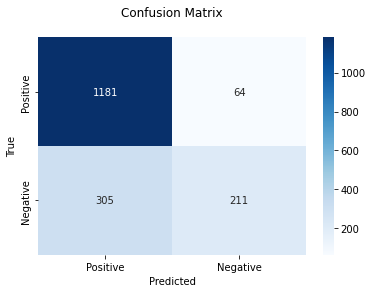

In [47]:
def plot_conf_matr(model_best, f_test, y_test):
    predictions = model_best.predict(f_test)
    print(f'Количество записей: {y_test.shape[0]}\n')

    cf_matrix = confusion_matrix(predictions, y_test)

    ax = sns.heatmap(cf_matrix, annot= True , fmt="d",  cmap='Blues')

    ax.set_title('Confusion Matrix\n');
    plt.xlabel("Predicted")
    plt.ylabel("True")


    ax.xaxis.set_ticklabels(['Positive','Negative'])
    ax.yaxis.set_ticklabels(['Positive','Negative'])
plot_conf_matr(best_model, features_test, target_test)

## Вывод:

Значение roc-auc на тестовой выборке: 0.87

Из построенной матрицы ошибок можно сделать вывод:

- значение PositivePositive (TruePositive) - 1191, т.е модель хорошо предсказывает пользователей, которые не уйдут.
- значение NegativePositive(false positive) - 295, т.е модель предсказала тех пользоывателей которые уйдут, но на самом деле они не уйдут. Правильных ответов - 1191 из 1253.
- Значение PositiveNegative (False negative) - 62, т.е модель промахивается в предсказании пользователей, которые уйдут. Неправильных ответов - 62 из 275.
- значение NegativeNegative ((TrueNegative) - 213, т.е модель верно предсказыват возможных 213 людей которые способны уйти и соответственно может им предложить бонус для удержания.


## Отчет по работе

На начальном этапе работы был проведен **предварительный анализ данных** четырёх датасетов. 

Подключены все необходимые библиотеки.

Вывел первые и последние 5 строк каждой, взглянул на признаки, на кол-во заполненных строк, тип данных каждого признака и проверил их на явные дубликаты.

В результате данного этапа были сделаны следующие выводы:

- В каждой таблице был столбец customerID по которому в дальнейшем нужно было объединить все 4 таблицы в одну;
-	Большинство признаков(столбцов) имели ответ 'Yes' или 'No', что наталкивает нас на мысль о кодировании;
-	Пропусков ни в одной из таблиц не наблюдалось;
-	Регистр названия столбцов нужно будет в предобработке перевести в нижний регистр и к нормальному виду кода;
-	Тип данных во всех таблицах, кроме таблицы с данными о договоре определен был верно;

В таблице с договором(df_contract) видно было невооруженным взглядом что столбцы:
1.	BeginDate и EndDate имеет неверный тип данных - нужно будет поменять на DateTime

2.	TotalCharges - также нужно будет поменять на float

Следующим этапом мы перешли к **Предобработке данных**

Сразу вспомним о цели задачи которая перед нами стояла - уйдет клиент или нет,  задача была определена как решение бинарной классификации.

В таблице df_contract были 2 столбца, BeginDate и EndDate:
1) BeginDate - это дата подключения, начала использования услуг клиентом оператора «Ниединогоразрыва.ком»

2) EndDate - дата отключения, или по другому - ухода клиента

Соответственно из этого следовал вывод, там где в признаке EndDate есть дата значит клиент ушел, там где его нет - клиент все еще продолжает пользоваться услугами.

На основании этого вывел новый признак таргет и в дальнейшем избавился от столбцов BeginDate и EndDate

Также в работе проверили целевой признак на дисбаланс – он был в пропорции 85% людей имеют класс 0 и лишь 15% класс - 1.

В ходе работы при попытке обучения модели возникли трудности с данными, произошел сбой и были обноружены не явные пропуски, в столбце TotalCharges, их было всего 11 – очень хотелось удалить, но нашлась взаимосвязь)
- Природа пропусков образована была , так как пользователи впервые подключились к оператору и данные потраченные за месяц еще не успели попасть в общие затраты за весь период, приравняли эти поля и  неявных пропусков больше не осталось;

- После заполнения пропусков в столбце TotalCharges  изменим тип данных с object на float. 

Далее было принято решение добавить еще 1 признак для лучшей работы модели обучения и получения более высокой метрики качества AUC ROC, этим признак стала продолжительность пользования оператором, я добавил во все поля EndDate конечную дата на момент анализа работы (согласно задааче) и вывел новый признак – duration.

- После чего объединили все таблицы через метод join left по ID.

Когда таблица была уже готова – привели названия всех столбцов к питоновскому стилю. 
На данном этапе предобработка была закончена и мы перешли к **Анализу данных.**

**Анализ данных и мультиколлинеарность**

Так как таблицы были разных размеров , после их объединения образовались пропуски в тех таблицах где строк было меньше чем в привалирующей – эти пропуски были заполнены текстовым значением ‘No’, что соответствовало общей картине бинарных признаков.

С помощью библиотеки phik был проведен анализ на мультиколлинеарность и выявлены нецелевые признаки которые имели высокую взаимосвязь между собой – что могло сказаться на обучении модели и привести к некорректному результату. 

В резульате такими признаками оказались:
- 'internet_service' - тип интернет-соединения (DSL, оптоволокно)
- 'streaming_t_v' - наличие услуги потокового телевидения
- 'streaming_movies' -  наличие услуги потокового просмотра фильмов
- total_charges - всего потрачено денег на услуги  (данный признак кореллировал с продолжительностью – но все же было принято решение в пользу признака duration, так как общие траты можно было сложить из ежемесячных, которые мы оставили в таблице).

Мы оставили следующий набор признаков для обучения:

- gender - пол	
- senior_citizen - наличие пенсионного статуса по возрасту 
- Partner – наличие супруга(и)
- dependents - наличие иждивенцев
- type -  тип оплаты: ежемесячный, годовой и тд
- paperless_billing - безналичный расчет
- payment_method - способ оплаты
- monthly_charges - ежемесячные траты на услуги 
- duration – продолжительность работы с оператором
- multiple_lines - наличие возможности ведения параллельных линий во время звонка
- online_security -  наличие услуги онлайн-безопасности 
- online_backup - наличие услуги онлайн-резервного копирования
- device_protection - наличие услуги защиты устройств
- tech_support - наличие услуги технической поддержки


Эти признаки сравнили их распределения для ушедших и оставшихся клиентов в виде диаграмм, в результате чего были сделаны следующие выводы:

- в 2,5 раза меньше людей уходят у которых есть партнер 700 против 250
- пол человека в данном случаи не оказывает существенного влияния, однако отметим при прочих равных мужчин уходит на несколько единиц больше, что в целом не влияет на общую картину;
- в 2 раза больше уходят и меняют оператора люди которые не имеют иждевенцев, вероятно они имеют больше времени на мониторинг и в этом смысле менее стабильны для компании, к ним нужно больше внимания и улучшения условий, хотя нельзя не заметить что в выборке количество таких клиентов тоже в 2 раза больше;
- тип контракта влияние на отток не оказывает, а если и оказывает то очень незначительное;
- клиенты оплачивающие безналичным расчетом в 2 раза более склонны к уходу нежели люди оплачивающие другой формой;
- отсутсвие услуги онлайн безопасности побуждает людей чаще менять оператора;
- уходящие клиенты чаще пенсионеры нежели наоборот;
-  OnlineBackup - наличие услуги онлайн-резервного копирования никак не оказывает влияния на отток клиентов;
- DeviceProtection - наличие услуги защиты устройств никак не оказывает влияния на отток клиентов;
- TechSupport - наличие услуги технической поддержки оказывает явное воздействие на отток, у тех клиентов у которых она отсутсвует;
- MultipleLines - наличие возможности ведения параллельных линий во время звонка оказывает воздействие на отток, у клиентов у которых она есть примерно в 2.5 раза чаще уходят.

Пенсионеры в общей выборке встречаются в 5 раз чаще, а люди оформившие подписку на месяц в 3 раза чаще. 

Уходящий клиент в основном отказывается от доп услуг для интернета.

Следующим этапом следовало **разделение на выборки** в соотношении определенным изначально 75% данных отвести на тренировочную и 25% на тестовую.

После чего чтобы модель могла точнее определять результат, произвели **кодирование признаков (данных)** через метод OHE.

Далее нужно было **обучить и выбрать модель** с лучшими параметрами для выхода на метрику качества **AUC ROC = 0,85** и выше.

Были рассмотрены две модели :

1)	CatBoostClassifier

2)	RandomForestClassifier

Изначально в работе мы должны были руководствоваться следующей константой для параметра random_state:
параметр RANDOM_STATE = 280823

Лучше всего себя проявила модель **CatBoostClassifier**


In [54]:
print("Лучшие параметры модели:", grid_search.best_params_)
print(f'Среднее значение AUC_ROC на кросвалидации тренировочной выборки:{scores.mean()}')
print("AUC_ROC на тестовой выборке:", auc_roc_cat)

Лучшие параметры модели: {'depth': 5, 'iterations': 150, 'learning_rate': 0.15}
Среднее значение AUC_ROC на кросвалидации тренировочной выборки:0.8549015568176181
AUC_ROC на тестовой выборке: 0.8744757127125903


После проверки на тестовой мы еще больше убедились в этом – ее результат вырос и метрика AUC ROC стала равна 0,87.

#### Это значит что цель работы достигнута, модель научилась прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

В результате от исходного плана работы не отступались.

Трудностями возникшими в ходе работы были следующие моменты:
- Правильная настройка использования новой для себя библиотки phik
- Неправильное кодирование данных тестовой выборки с помощью OHE(one hot encoding) , в результате чего происходило подглядывание, после исправления данной ошибки работа была принята. 

И финально по ключевым этапам работы, я считаю каждый этап важным и нельзя недооценивать не один из них, просто всегда нужно понимать что от того, как ты начнешь, а как правило начало – это предварительный анализ исходных данных и их предобработка, зависят следующие этапы работы. 

На этом по умозаключениям у меня все – жду рекомендаций по исправлениям или дополнениям)


https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_